In [ ]:
!pip install catboost

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install hyperopt

In [4]:
import math

from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix, eval_metric

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from hyperopt import hp, fmin, tpe, STATUS_OK


from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [5]:
RANDOM_SEED = 42

# InceptionV3 Features

In [6]:
incV3_train = pd.read_csv('../inception-resnet-v2/inception-v3-data/inception_train.csv')
incV3_valid = pd.read_csv('../inception-resnet-v2/inception-v3-data/inception_valid.csv')
incV3_test = pd.read_csv('../inception-resnet-v2/inception-v3-data/inception_test.csv')

In [7]:
incV3_combined = pd.concat([incV3_train, incV3_valid, incV3_test])

In [11]:
incV3_combined.head()

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,incV3_10,incV3_11,incV3_12,incV3_13,incV3_14,incV3_15,incV3_16,incV3_17,incV3_18,incV3_19,incV3_20,incV3_21,incV3_22,incV3_23,incV3_24,incV3_25,incV3_26,incV3_27,incV3_28,incV3_29,incV3_30,incV3_31,incV3_32,incV3_33,incV3_34,incV3_35,incV3_36,incV3_37,incV3_38,incV3_39,...,incV3_2010,incV3_2011,incV3_2012,incV3_2013,incV3_2014,incV3_2015,incV3_2016,incV3_2017,incV3_2018,incV3_2019,incV3_2020,incV3_2021,incV3_2022,incV3_2023,incV3_2024,incV3_2025,incV3_2026,incV3_2027,incV3_2028,incV3_2029,incV3_2030,incV3_2031,incV3_2032,incV3_2033,incV3_2034,incV3_2035,incV3_2036,incV3_2037,incV3_2038,incV3_2039,incV3_2040,incV3_2041,incV3_2042,incV3_2043,incV3_2044,incV3_2045,incV3_2046,incV3_2047,incV3_file_id,incV3_label
0,0.303634,0.318942,0.208411,0.477266,0.068431,0.106686,0.048553,0.459468,0.139828,0.271657,0.121587,0.595600,0.150126,0.067441,0.066815,0.083468,0.180686,0.121065,0.359528,0.173691,0.707666,0.252425,0.250225,0.049604,0.159554,0.495302,0.033799,0.082667,0.620989,0.186894,0.170015,0.517833,0.321700,0.507045,0.094852,0.369974,0.432739,0.118659,0.265348,0.041560,...,1.088839,1.008713,0.000000,0.095373,0.199698,0.491798,0.004208,0.191066,0.878754,0.069308,0.128670,0.461246,0.011548,0.094069,0.511283,0.273566,0.064044,0.220091,0.037410,0.170411,0.456357,0.109208,0.024379,0.016142,0.309050,0.069353,0.562461,0.387386,0.012380,0.321861,0.258009,0.145014,0.247663,0.095321,0.095406,0.963429,0.372782,0.155981,dress/009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg,0
1,0.047840,0.264508,0.390923,0.142860,0.129282,0.150060,0.069824,0.481221,0.330697,0.258998,0.284957,0.839510,0.049135,0.618441,0.179566,0.189002,0.462456,0.189369,0.565357,0.154353,0.307762,0.864665,0.067912,0.126575,0.001754,0.088215,0.099797,0.252185,0.084816,0.116371,0.036080,0.105320,0.233524,0.321487,0.149458,0.220641,0.585277,0.099793,0.514470,0.380777,...,0.715627,0.370913,0.273533,0.010923,0.011349,0.506104,0.337167,0.288517,0.037845,1.162125,0.040779,0.245147,0.165474,1.019356,0.193412,0.202823,0.178313,0.445691,0.049239,0.440084,0.194088,0.737271,0.300493,0.028328,0.713750,0.076088,0.390142,0.921957,1.113839,0.258573,0.154730,0.096029,0.042481,0.408144,0.082131,0.573751,2.442517,0.437859,dress/041c6bde-e737-46fd-9586-984c1503941f.jpg,0
2,0.942071,0.434878,0.697832,0.251812,0.220720,0.003102,0.142887,0.486080,0.071632,0.570452,0.097671,0.651522,0.719168,0.053366,0.014031,0.258985,0.017525,0.251536,0.039473,0.464952,0.114880,0.528741,0.153433,1.346469,0.662280,0.366115,0.338587,1.014719,0.705959,0.692436,0.546387,0.272917,0.147378,0.947167,0.393558,0.647714,0.256697,0.048100,0.022955,0.152845,...,0.436633,0.024284,0.160562,1.107060,0.065783,0.091846,0.004797,0.003688,0.085345,0.102019,0.090384,0.189360,1.225240,0.023228,0.116584,0.608024,0.013252,0.640213,0.032915,0.045562,0.961790,0.484170,0.080594,0.052586,0.022498,0.867815,0.312391,0.564246,0.321194,0.592843,0.134994,0.105694,0.033259,0.111998,0.370574,0.410654,0.574305,0.041574,dress/04f0b07f-4b9f-4c55-bc5d-b693658fb32c.jpg,0
3,0.279040,0.390771,0.115167,0.213695,0.314327,0.105088,0.064898,0.193854,0.482503,0.612311,0.023051,0.299320,0.385382,0.034609,0.078219,0.000000,0.103029,0.182695,0.254550,0.085456,0.239777,0.053341,0.386832,0.138270,0.540089,0.759730,0.131251,0.146809,0.068016,0.185173,0.187190,0.187758,0.240439,0.622536,0.155416,0.270894,0.059817,0.027796,0.044293,0.424808,...,0.299911,0.645781,0.001107,0.214570,0.388039,0.052443,0.000000,0.070712,0.159960,0.070866,0.219171,0.161842,0.634883,0.042230,1.003714,0.161258,0.087194,0.443433,0.036886,0.255009,0.000000,0.165857,0.072062,0.079825,0.175955,0.229562,0.611858,0.240544,0.888975,0.769011,0.005990,0.239939,0.306121,0.027214,0.116109,0.686962,0.478834,0.350503,dress/053689bb-5928-489b-aeaf-dfb969b05e93.jpg,0
4,0.567760,0.119651,0.390262,0.429970,0.153197,0.227783,0.506306,0.387863,0.170855,0.258183,0.099920,0.339112,0.369342,0.195935,0.053978,0.051300,0.082272,0.470346,0.497293,

In [18]:
labels_frequency.index

Int64Index([9, 2, 4, 5, 6, 0, 7, 3, 1, 8], dtype='int64')

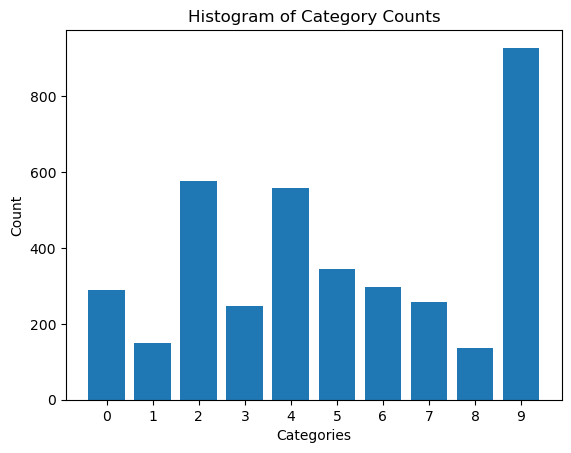

In [22]:
labels_frequency = incV3_combined['incV3_label'].value_counts()
plt.bar(labels_frequency.index, labels_frequency.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks([9, 2, 4, 5, 6, 0, 7, 3, 1, 8])
plt.title('Histogram of Category Counts')
plt.show();

In [10]:
incV3_combined.duplicated().sum()

0

In [27]:
incV3_combined.shape

(3781, 2050)

# Xception Features

In [8]:
xc_train = pd.read_csv('../xception-data/xception_train.csv')
xc_valid = pd.read_csv('../xception-data/xception_valid.csv')
xc_test = pd.read_csv('../xception-data/xception_test.csv')

In [9]:
xc_combined = pd.concat([xc_train, xc_valid, xc_test])

In [25]:
xc_combined.duplicated().sum()

0

In [26]:
xc_combined.shape

(3781, 2050)

# VGG19 Features

In [10]:
vgg19_train = pd.read_csv('../inception-resnet-v2/vgg19-data/vgg19_train.csv')
vgg19_valid = pd.read_csv('../inception-resnet-v2/vgg19-data/vgg19_valid.csv')
vgg19_test = pd.read_csv('../inception-resnet-v2/vgg19-data/vgg19_test.csv')

In [11]:
vgg19_combined = pd.concat([vgg19_train, vgg19_valid, vgg19_test])

In [30]:
vgg19_combined.duplicated().sum()

0

In [31]:
vgg19_combined.shape

(3781, 514)

 ---

# >> CatBoost (InceptionV3 Featuers)

In [66]:
#Defining train/valid/test split
X_full, X_test, y_full, y_test = train_test_split(incV3_combined, incV3_combined['incV3_label'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.25, random_state=42)

In [67]:
X_full = X_full.drop(['incV3_file_id', 'incV3_label'], axis=1).reset_index(drop=True)
X_train = X_train.drop(['incV3_file_id', 'incV3_label'], axis=1).reset_index(drop=True)
X_valid = X_valid.drop(['incV3_file_id', 'incV3_label'], axis=1).reset_index(drop=True)
X_test = X_test.drop(['incV3_file_id', 'incV3_label'], axis=1).reset_index(drop=True)

In [72]:
y_full = y_full.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [74]:
full_pool = Pool(
    data = X_full,
    label = y_full,
)

train_pool = Pool(
    data = X_train,
    label = y_train,
)

validation_pool = Pool(
    data = X_valid,
    label = y_valid,
)

test_pool = Pool(
    data = X_test,
    label = y_test,
)

## "Out of the box" Classifier

In [103]:
#Out of the box classifier
v3_classifier = CatBoostClassifier(
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'Accuracy'
                    )

In [104]:
v3_classifier.fit(train_pool,
          eval_set=validation_pool,
          verbose=200)

Learning rate set to 0.114222
0:	learn: 0.5952381	test: 0.5529101	best: 0.5529101 (0)	total: 95.5ms	remaining: 1m 35s
200:	learn: 0.9885362	test: 0.8373016	best: 0.8439153 (173)	total: 15.7s	remaining: 1m 2s
400:	learn: 1.0000000	test: 0.8439153	best: 0.8478836 (398)	total: 30s	remaining: 44.8s
600:	learn: 1.0000000	test: 0.8505291	best: 0.8544974 (503)	total: 44.4s	remaining: 29.5s
800:	learn: 1.0000000	test: 0.8584656	best: 0.8597884 (790)	total: 59s	remaining: 14.7s
999:	learn: 1.0000000	test: 0.8611111	best: 0.8637566 (940)	total: 1m 13s	remaining: 0us
bestTest = 0.8637566138
bestIteration = 940
Shrink model to first 941 iterations.


In [105]:
v3_classifier.get_evals_result()['learn'].keys()

dict_keys(['Accuracy', 'MultiClass'])

## Train VS Validation Error

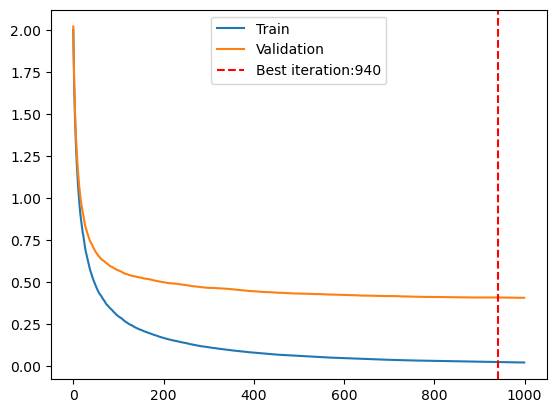

In [106]:
best_iteration = v3_classifier.best_iteration_
plt.plot(v3_classifier.get_evals_result()['learn']['MultiClass'], label = "Train")
plt.plot(v3_classifier.get_evals_result()['validation']['MultiClass'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

## Accuracy

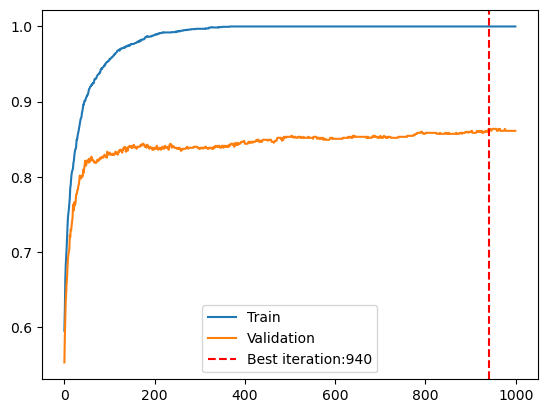

In [107]:
plt.plot(v3_classifier.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(v3_classifier.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

In [108]:
v3_classifier.get_best_score()

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.021340768803995123},
 'validation': {'Accuracy': 0.8637566137566137,
  'MultiClass': 0.40685050197379297}}

## Confusion Matrix

In [109]:
cm = get_confusion_matrix(v3_classifier, test_pool)

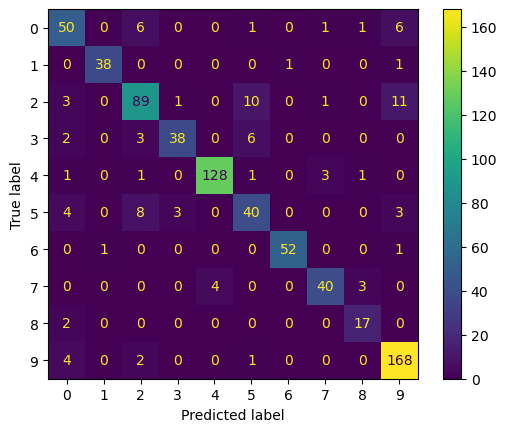

In [110]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=v3_classifier.classes_)
disp.plot();

In [111]:
y_test.value_counts()

9    175
4    135
2    115
0     65
5     58
6     54
3     49
7     47
1     40
8     19
Name: incV3_label, dtype: int64

## Overfitting detection

In this case since we explicitly stated `eval_metric='Accuracy'` then instead of `loss_function = 'MultiClass'` (which is by default) we will trace `early_stopping_rounds=50` for `Accuracy` score.

In [113]:
#Out of the box classifier
v3_classifier = CatBoostClassifier(
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'Accuracy',
                    early_stopping_rounds = 50
                    )

v3_classifier.fit(train_pool,
          eval_set=validation_pool,
          verbose=200)

Learning rate set to 0.114222
0:	learn: 0.5952381	test: 0.5529101	best: 0.5529101 (0)	total: 94.7ms	remaining: 1m 34s
200:	learn: 0.9885362	test: 0.8373016	best: 0.8439153 (173)	total: 15.7s	remaining: 1m 2s
bestTest = 0.8439153439
bestIteration = 173
Shrink model to first 174 iterations.


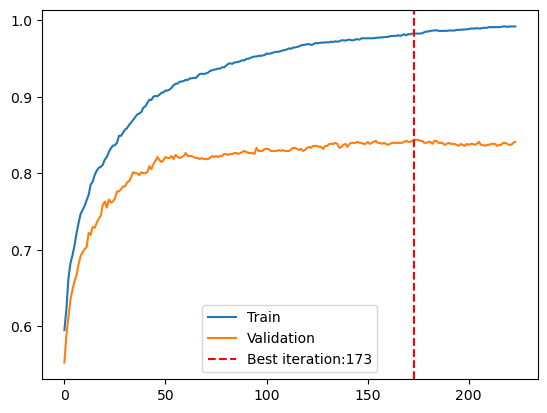

In [115]:
best_iteration = v3_classifier.best_iteration_
plt.plot(v3_classifier.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(v3_classifier.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

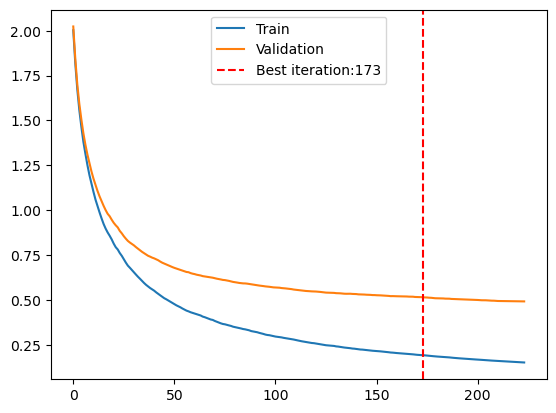

In [116]:
plt.plot(v3_classifier.get_evals_result()['learn']['MultiClass'], label = "Train")
plt.plot(v3_classifier.get_evals_result()['validation']['MultiClass'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

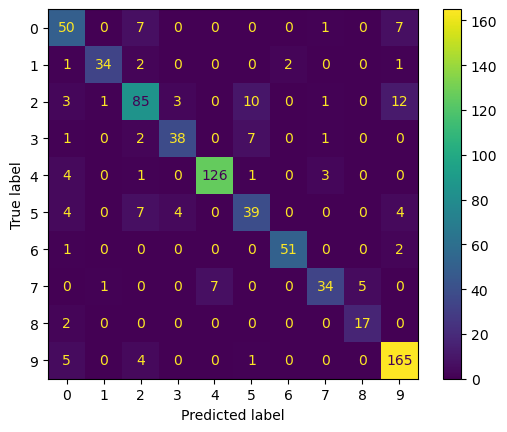

In [117]:
cm = get_confusion_matrix(v3_classifier, test_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=v3_classifier.classes_)
disp.plot();

In [118]:
v3_classifier.get_best_score()

{'learn': {'Accuracy': 0.9920634920634921, 'MultiClass': 0.15171649805031967},
 'validation': {'Accuracy': 0.843915343915344,
  'MultiClass': 0.4920479103370949}}

## Tuning the model

In [178]:
def hyperopt_objective(params):
    print(params)
    model = CatBoostClassifier(**params,
                               #task_type = 'GPU',
                               early_stopping_rounds=50,
                               loss_function = 'MultiClass',
                               random_seed = RANDOM_SEED)
    
    model.fit(train_pool, verbose=0, eval_set=validation_pool)
    
    y_valid = validation_pool.get_label()
    y_pred = model.predict_proba(validation_pool)
    return  -eval_metric(y_valid, y_pred, 'Accuracy')[0]

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.randint('depth', 4, 10),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

In [ ]:
#It took around 21mins on Saturn Cloud (T4-XLarge - 4 cores - 16 GB RAM - 1 GPU (Tesla P4) - 10Gi Disk)
# best = fmin(hyperopt_objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10,
#             rstate=np.random.default_rng(RANDOM_SEED))

In [168]:
best_params = {'depth': 7,
               'l2_leaf_reg': 2.909954052940017,
               'learning_rate': 0.046339990323578134}

In [169]:
model = CatBoostClassifier(**best_params,
                               task_type = 'GPU',
                               loss_function = 'MultiClass',
                               eval_metric = 'MultiClass',
                               custom_loss= ['Accuracy'],
                               random_seed = RANDOM_SEED)
    
model.fit(train_pool, verbose=100, eval_set=validation_pool)

0:	learn: 2.1669463	test: 2.1711051	best: 2.1711051 (0)	total: 153ms	remaining: 2m 33s
100:	learn: 0.5032672	test: 0.7291554	best: 0.7291554 (100)	total: 16.2s	remaining: 2m 24s
200:	learn: 0.2978508	test: 0.6008229	best: 0.6008229 (200)	total: 30.9s	remaining: 2m 2s
300:	learn: 0.2074929	test: 0.5449385	best: 0.5449385 (300)	total: 44.7s	remaining: 1m 43s
400:	learn: 0.1598361	test: 0.5144761	best: 0.5144761 (400)	total: 57.8s	remaining: 1m 26s
500:	learn: 0.1278906	test: 0.4942862	best: 0.4942862 (500)	total: 1m 10s	remaining: 1m 10s
600:	learn: 0.1054315	test: 0.4779854	best: 0.4779854 (600)	total: 1m 23s	remaining: 55.5s
700:	learn: 0.0878831	test: 0.4647899	best: 0.4647899 (700)	total: 1m 36s	remaining: 41.2s
800:	learn: 0.0742222	test: 0.4550239	best: 0.4550239 (800)	total: 1m 49s	remaining: 27.2s
900:	learn: 0.0635494	test: 0.4470704	best: 0.4470704 (900)	total: 2m 2s	remaining: 13.5s
999:	learn: 0.0548858	test: 0.4374532	best: 0.4374532 (999)	total: 2m 15s	remaining: 0us
bestTe

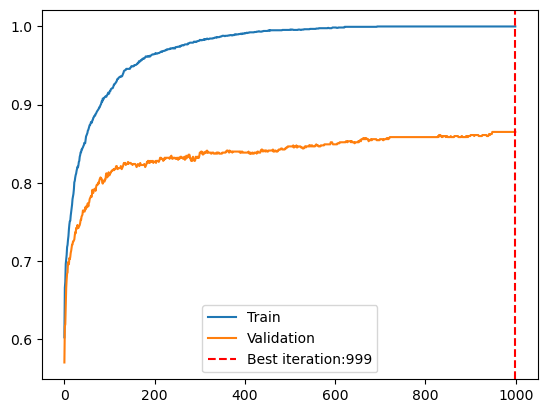

In [173]:
best_iteration = model.best_iteration_
plt.plot(model.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(model.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

In [174]:
model.best_score_

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.05488581043492339},
 'validation': {'Accuracy': 0.8650793650793651,
  'MultiClass': 0.4374531740864749}}

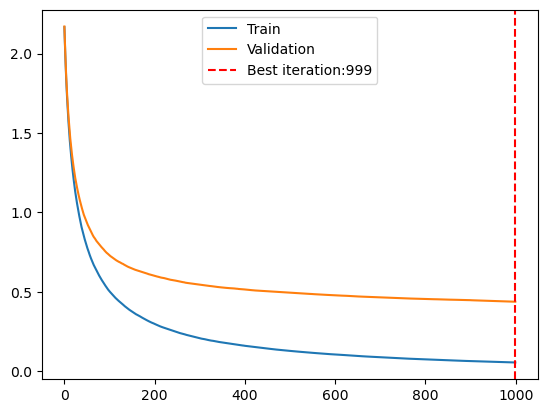

In [175]:
plt.plot(model.get_evals_result()['learn']['MultiClass'], label = "Train")
plt.plot(model.get_evals_result()['validation']['MultiClass'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

# >> CatBoost (Xception Features)

In [180]:
xc_combined.columns

Index(['xc_0', 'xc_1', 'xc_2', 'xc_3', 'xc_4', 'xc_5', 'xc_6', 'xc_7', 'xc_8',
       'xc_9',
       ...
       'xc_2040', 'xc_2041', 'xc_2042', 'xc_2043', 'xc_2044', 'xc_2045',
       'xc_2046', 'xc_2047', 'xc_file_id', 'xc_label'],
      dtype='object', length=2050)

In [181]:
#Defining train/valid/test split
X_full, X_test, y_full, y_test = train_test_split(xc_combined, xc_combined['xc_label'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.25, random_state=42)

In [182]:
X_full = X_full.drop(['xc_file_id', 'xc_label'], axis=1).reset_index(drop=True)
X_train = X_train.drop(['xc_file_id', 'xc_label'], axis=1).reset_index(drop=True)
X_valid = X_valid.drop(['xc_file_id', 'xc_label'], axis=1).reset_index(drop=True)
X_test = X_test.drop(['xc_file_id', 'xc_label'], axis=1).reset_index(drop=True)

In [192]:
y_full = y_full.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [184]:
full_pool = Pool(
    data = X_full,
    label = y_full,
)

train_pool = Pool(
    data = X_train,
    label = y_train,
)

validation_pool = Pool(
    data = X_valid,
    label = y_valid,
)

test_pool = Pool(
    data = X_test,
    label = y_test,
)

In [186]:
xc_classifier = CatBoostClassifier(
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'Accuracy',
                    early_stopping_rounds = 50
                    )

xc_classifier.fit(train_pool,
          eval_set=validation_pool,
          verbose=200)

Learning rate set to 0.114222
0:	learn: 0.5974427	test: 0.5595238	best: 0.5595238 (0)	total: 82.5ms	remaining: 1m 22s
bestTest = 0.8267195767
bestIteration = 64
Shrink model to first 65 iterations.


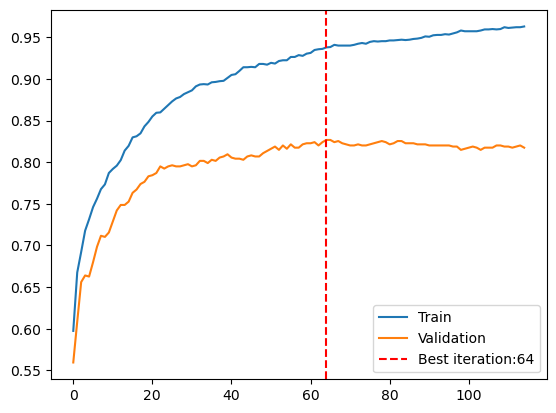

In [187]:
best_iteration = xc_classifier.best_iteration_
plt.plot(xc_classifier.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(xc_classifier.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

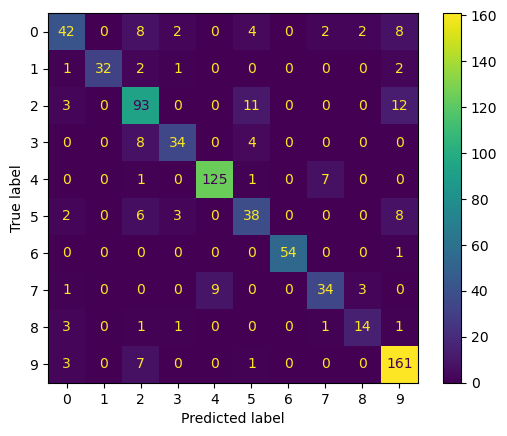

In [190]:
cm = get_confusion_matrix(xc_classifier, test_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=xc_classifier.classes_)
disp.plot();

In [189]:
xc_classifier.best_score_

{'learn': {'Accuracy': 0.9629629629629629, 'MultiClass': 0.2471420314997382},
 'validation': {'Accuracy': 0.8267195767195767,
  'MultiClass': 0.5185345846509176}}

# >> CatBoost (VGG19 Features)

In [197]:
#Defining train/valid/test split
X_full, X_test, y_full, y_test = train_test_split(vgg19_combined, vgg19_combined['vgg19_label'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.25, random_state=42)

In [198]:
X_full = X_full.drop(['vgg19_file_id', 'vgg19_label'], axis=1).reset_index(drop=True)
X_train = X_train.drop(['vgg19_file_id', 'vgg19_label'], axis=1).reset_index(drop=True)
X_valid = X_valid.drop(['vgg19_file_id', 'vgg19_label'], axis=1).reset_index(drop=True)
X_test = X_test.drop(['vgg19_file_id', 'vgg19_label'], axis=1).reset_index(drop=True)

In [199]:
y_full = y_full.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [200]:
full_pool = Pool(
    data = X_full,
    label = y_full,
)

train_pool = Pool(
    data = X_train,
    label = y_train,
)

validation_pool = Pool(
    data = X_valid,
    label = y_valid,
)

test_pool = Pool(
    data = X_test,
    label = y_test,
)

In [201]:
vgg19_classifier = CatBoostClassifier(
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'Accuracy',
                    early_stopping_rounds = 50
                    )

vgg19_classifier.fit(train_pool,
          eval_set=validation_pool,
          verbose=200)

Learning rate set to 0.114222
0:	learn: 0.5277778	test: 0.5079365	best: 0.5079365 (0)	total: 29.9ms	remaining: 29.9s
200:	learn: 0.9969136	test: 0.8214286	best: 0.8214286 (200)	total: 4.72s	remaining: 18.8s
bestTest = 0.8214285714
bestIteration = 200
Shrink model to first 201 iterations.


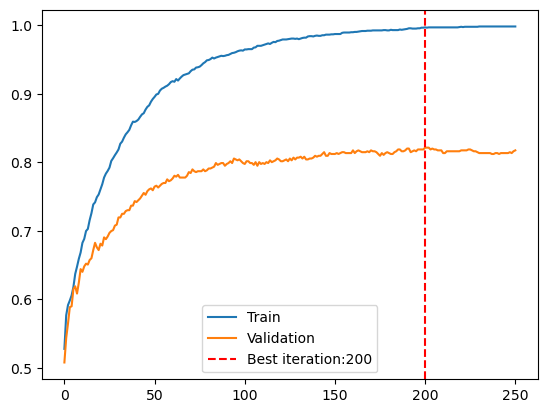

In [202]:
best_iteration = vgg19_classifier.best_iteration_
plt.plot(vgg19_classifier.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(vgg19_classifier.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

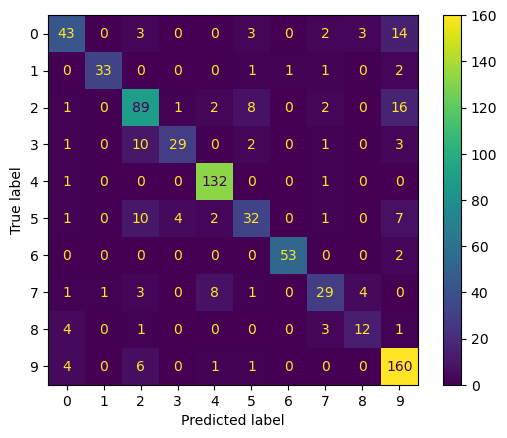

In [204]:
cm = get_confusion_matrix(vgg19_classifier, test_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=vgg19_classifier.classes_)
disp.plot();

In [205]:
vgg19_classifier.best_score_

{'learn': {'Accuracy': 0.9982363315696648, 'MultiClass': 0.16059361479690257},
 'validation': {'Accuracy': 0.8214285714285714,
  'MultiClass': 0.5832254722635583}}

# Model Comparison

In [230]:
v3_accuracy = pd.DataFrame(v3_classifier.best_score_).head(1).reset_index(drop=True)
v3_accuracy['model'] = 'InceptionV3'

xc_accuracy = pd.DataFrame(xc_classifier.best_score_).head(1).reset_index(drop=True)
xc_accuracy['model'] = 'Xception'

vgg19_accuracy = pd.DataFrame(vgg19_classifier.best_score_).head(1).reset_index(drop=True)
vgg19_accuracy['model'] = 'VGG19'

pd.concat([v3_accuracy, xc_accuracy, vgg19_accuracy]).reset_index(drop=True)

,learn,validation,model
0,0.992063,0.843915,InceptionV3
1,0.962963,0.826720,Xception
2,0.998236,0.821429,VGG19


# Combining all features
---

## Strategy

In [252]:
df_1 = incV3_combined.head(1)
df_2 = xc_combined.head(1)
df_3 = vgg19_combined.head(1)

In [253]:
df_1

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,incV3_10,incV3_11,incV3_12,incV3_13,incV3_14,incV3_15,incV3_16,incV3_17,incV3_18,incV3_19,incV3_20,incV3_21,incV3_22,incV3_23,incV3_24,incV3_25,incV3_26,incV3_27,incV3_28,incV3_29,incV3_30,incV3_31,incV3_32,incV3_33,incV3_34,incV3_35,incV3_36,incV3_37,incV3_38,incV3_39,...,incV3_2010,incV3_2011,incV3_2012,incV3_2013,incV3_2014,incV3_2015,incV3_2016,incV3_2017,incV3_2018,incV3_2019,incV3_2020,incV3_2021,incV3_2022,incV3_2023,incV3_2024,incV3_2025,incV3_2026,incV3_2027,incV3_2028,incV3_2029,incV3_2030,incV3_2031,incV3_2032,incV3_2033,incV3_2034,incV3_2035,incV3_2036,incV3_2037,incV3_2038,incV3_2039,incV3_2040,incV3_2041,incV3_2042,incV3_2043,incV3_2044,incV3_2045,incV3_2046,incV3_2047,incV3_file_id,incV3_label
0,0.303634,0.318942,0.208411,0.477266,0.068431,0.106686,0.048553,0.459468,0.139828,0.271657,0.121587,0.5956,0.150126,0.067441,0.066815,0.083468,0.180686,0.121065,0.359528,0.173691,0.707666,0.252425,0.250225,0.049604,0.159554,0.495302,0.033799,0.082667,0.620989,0.186894,0.170015,0.517833,0.3217,0.507045,0.094852,0.369974,0.432739,0.118659,0.265348,0.04156,...,1.088839,1.008713,0.0,0.095373,0.199698,0.491798,0.004208,0.191066,0.878754,0.069308,0.12867,0.461246,0.011548,0.094069,0.511283,0.273566,0.064044,0.220091,0.03741,0.170411,0.456357,0.109208,0.024379,0.016142,0.30905,0.069353,0.562461,0.387386,0.01238,0.321861,0.258009,0.145014,0.247663,0.095321,0.095406,0.963429,0.372782,0.155981,dress/009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg,0


In [254]:
merged_df = pd.merge(df_1, df_2, left_on='incV3_file_id', right_on='xc_file_id', how='inner')
merged_df

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,incV3_10,incV3_11,incV3_12,incV3_13,incV3_14,incV3_15,incV3_16,incV3_17,incV3_18,incV3_19,incV3_20,incV3_21,incV3_22,incV3_23,incV3_24,incV3_25,incV3_26,incV3_27,incV3_28,incV3_29,incV3_30,incV3_31,incV3_32,incV3_33,incV3_34,incV3_35,incV3_36,incV3_37,incV3_38,incV3_39,...,xc_2010,xc_2011,xc_2012,xc_2013,xc_2014,xc_2015,xc_2016,xc_2017,xc_2018,xc_2019,xc_2020,xc_2021,xc_2022,xc_2023,xc_2024,xc_2025,xc_2026,xc_2027,xc_2028,xc_2029,xc_2030,xc_2031,xc_2032,xc_2033,xc_2034,xc_2035,xc_2036,xc_2037,xc_2038,xc_2039,xc_2040,xc_2041,xc_2042,xc_2043,xc_2044,xc_2045,xc_2046,xc_2047,xc_file_id,xc_label
0,0.303634,0.318942,0.208411,0.477266,0.068431,0.106686,0.048553,0.459468,0.139828,0.271657,0.121587,0.5956,0.150126,0.067441,0.066815,0.083468,0.180686,0.121065,0.359528,0.173691,0.707666,0.252425,0.250225,0.049604,0.159554,0.495302,0.033799,0.082667,0.620989,0.186894,0.170015,0.517833,0.3217,0.507045,0.094852,0.369974,0.432739,0.118659,0.265348,0.04156,...,0.0,0.083075,0.012938,0.430549,0.0,0.004804,0.613575,0.0,0.006198,0.006632,0.254017,0.000452,0.039395,0.394529,0.014034,0.284256,0.134729,0.0,0.042053,0.001156,0.209599,0.200103,0.000394,0.165083,0.073553,0.057416,0.068703,0.18436,0.168874,0.043352,0.0546,0.406961,0.141699,0.0,0.0,0.0,0.180063,0.0,dress/009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg,0


In [255]:
'incV3_file_id' in merged_df.columns, 'incV3_label' in merged_df.columns

(True, True)

In [256]:
merged_df = pd.merge(merged_df, df_3, left_on='incV3_file_id', right_on='vgg19_file_id', how='inner')
merged_df.columns

Index(['incV3_0', 'incV3_1', 'incV3_2', 'incV3_3', 'incV3_4', 'incV3_5',
       'incV3_6', 'incV3_7', 'incV3_8', 'incV3_9',
       ...
       'vgg19_504', 'vgg19_505', 'vgg19_506', 'vgg19_507', 'vgg19_508',
       'vgg19_509', 'vgg19_510', 'vgg19_511', 'vgg19_file_id', 'vgg19_label'],
      dtype='object', length=4614)

In [246]:
'incV3_file_id' in merged_df.columns, 'vgg19_file_id' in merged_df.columns, 'xc_file_id' in merged_df.columns

(True, True, True)

In [257]:
columns_to_drop = ['incV3_file_id', 'xc_file_id', 'incV3_label', 'xc_label']
merged_df = merged_df.drop(columns=columns_to_drop)

In [258]:
'incV3_file_id' in merged_df.columns, 'vgg19_file_id' in merged_df.columns, 'xc_file_id' in merged_df.columns, \
'incV3_label' in merged_df.columns, 'vgg19_label' in merged_df.columns, 'xc_label' in merged_df.columns

(False, True, False, False, True, False)

In [260]:
# Rename a column
new_column_names = {'vgg19_file_id': 'file_id', 'vgg19_label': 'label'}
merged_df.rename(columns= new_column_names, inplace=True)

In [261]:
'incV3_file_id' in merged_df.columns, 'vgg19_file_id' in merged_df.columns, 'xc_file_id' in merged_df.columns, \
'incV3_label' in merged_df.columns, 'vgg19_label' in merged_df.columns, 'xc_label' in merged_df.columns

(False, False, False, False, False, False)

In [262]:
merged_df.head()

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,incV3_10,incV3_11,incV3_12,incV3_13,incV3_14,incV3_15,incV3_16,incV3_17,incV3_18,incV3_19,incV3_20,incV3_21,incV3_22,incV3_23,incV3_24,incV3_25,incV3_26,incV3_27,incV3_28,incV3_29,incV3_30,incV3_31,incV3_32,incV3_33,incV3_34,incV3_35,incV3_36,incV3_37,incV3_38,incV3_39,...,vgg19_474,vgg19_475,vgg19_476,vgg19_477,vgg19_478,vgg19_479,vgg19_480,vgg19_481,vgg19_482,vgg19_483,vgg19_484,vgg19_485,vgg19_486,vgg19_487,vgg19_488,vgg19_489,vgg19_490,vgg19_491,vgg19_492,vgg19_493,vgg19_494,vgg19_495,vgg19_496,vgg19_497,vgg19_498,vgg19_499,vgg19_500,vgg19_501,vgg19_502,vgg19_503,vgg19_504,vgg19_505,vgg19_506,vgg19_507,vgg19_508,vgg19_509,vgg19_510,vgg19_511,file_id,label
0,0.303634,0.318942,0.208411,0.477266,0.068431,0.106686,0.048553,0.459468,0.139828,0.271657,0.121587,0.5956,0.150126,0.067441,0.066815,0.083468,0.180686,0.121065,0.359528,0.173691,0.707666,0.252425,0.250225,0.049604,0.159554,0.495302,0.033799,0.082667,0.620989,0.186894,0.170015,0.517833,0.3217,0.507045,0.094852,0.369974,0.432739,0.118659,0.265348,0.04156,...,2.770024,0.085181,0.0,0.642054,2.681654,0.618706,2.481767,1.377977,0.298981,0.861671,2.299908,0.07995,2.124256,0.912831,0.506263,2.018078,0.0,0.116209,0.86124,0.031939,2.45892,2.879396,0.0,0.14362,1.077123,0.149725,0.035521,0.0,0.81098,6.850159,0.116475,3.400921,3.61181,0.831427,1.011819,0.470787,0.933962,0.0,dress/009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg,0


## Execution

In [12]:
#Merging incV3_combined with xc_combined
merged_df = pd.merge(incV3_combined, xc_combined, left_on='incV3_file_id', right_on='xc_file_id', how='inner')

#Then past merged_df combining with vgg19_combined
merged_df = pd.merge(merged_df, vgg19_combined, left_on='incV3_file_id', right_on='vgg19_file_id', how='inner')

#Dropping redundant columns
columns_to_drop = ['incV3_file_id', 'xc_file_id', 'incV3_label', 'xc_label']
merged_df = merged_df.drop(columns=columns_to_drop)

#Updating the column names for file_id and label
new_column_names = {'vgg19_file_id': 'file_id', 'vgg19_label': 'label'}
merged_df.rename(columns= new_column_names, inplace=True)

## Extracting merged_df (Run these only if you want to extract the `merged_df`)

In [13]:
merged_df.head()

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,...,vgg19_504,vgg19_505,vgg19_506,vgg19_507,vgg19_508,vgg19_509,vgg19_510,vgg19_511,file_id,label
0,0.303634,0.318942,0.208411,0.477266,0.068431,0.106686,0.048553,0.459468,0.139828,0.271657,...,0.116475,3.400921,3.611810,0.831427,1.011819,0.470787,0.933962,0.000000,dress/009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg,0
1,0.047840,0.264508,0.390923,0.142860,0.129282,0.150060,0.069824,0.481221,0.330697,0.258998,...,10.499381,2.195004,18.171705,1.706563,0.722449,0.958704,5.522590,0.298218,dress/041c6bde-e737-46fd-9586-984c1503941f.jpg,0
2,0.942071,0.434878,0.697832,0.251812,0.220720,0.003102,0.142887,0.486080,0.071632,0.570452,...,0.823151,2.738157,3.098589,12.312897,2.469384,0.712025,1.020714,1.618408,dress/04f0b07f-4b9f-4c55-bc5d-b693658fb32c.jpg,0
3,0.279040,0.390771,0.115167,0.213695,0.314327,0.105088,0.064898,0.193854,0.482503,0.612311,...,1.585208,1.675288,6.131248,0.140504,10.127681,0.611325,2.268990,0.110608,dress/053689bb-5928-489b-aeaf-dfb969b05e93.jpg,0
4,0.567760,0.119651,0.390262,0.429970,0.153197,0.227783,0.506306,0.387863,0.170855,0.258183,...,3.026077,14.017796,0.781647,0.939281,1.200090,1.347519,0.297584,0.198936,dress/0546d34a-a369-4723-8d3a-74c0f51af26c.jpg,0


In [15]:
merged_df.columns.str.contains('file_id').sum(), merged_df.columns.str.contains('label').sum()

(1, 1)

In [14]:
merged_df.columns.str.contains('vgg19').sum(), merged_df.columns.str.contains('xc').sum(), merged_df.columns.str.contains('incV3').sum()

(512, 2048, 2048)

In [16]:
!ls

catboost_info		testing-models.ipynb  Untitled.ipynb
test-if-it-works.ipynb	testing-wine.ipynb


In [17]:
merged_df.to_csv('./cp-calibration/combined-features.csv', index=False)

In [18]:
pd.read_csv('./cp-calibration/combined-features.csv').head()

,incV3_0,incV3_1,incV3_2,incV3_3,incV3_4,incV3_5,incV3_6,incV3_7,incV3_8,incV3_9,...,vgg19_504,vgg19_505,vgg19_506,vgg19_507,vgg19_508,vgg19_509,vgg19_510,vgg19_511,file_id,label
0,0.303634,0.318942,0.208411,0.477266,0.068431,0.106686,0.048553,0.459468,0.139828,0.271657,...,0.116475,3.400921,3.611810,0.831427,1.011819,0.470787,0.933962,0.000000,dress/009b3c31-fb62-45c0-be9a-37a5c238cb88.jpg,0
1,0.047840,0.264508,0.390923,0.142860,0.129282,0.150060,0.069824,0.481221,0.330697,0.258998,...,10.499381,2.195004,18.171705,1.706563,0.722449,0.958704,5.522590,0.298218,dress/041c6bde-e737-46fd-9586-984c1503941f.jpg,0
2,0.942071,0.434878,0.697832,0.251812,0.220720,0.003102,0.142887,0.486080,0.071632,0.570452,...,0.823151,2.738157,3.098589,12.312897,2.469384,0.712025,1.020714,1.618408,dress/04f0b07f-4b9f-4c55-bc5d-b693658fb32c.jpg,0
3,0.279040,0.390771,0.115167,0.213695,0.314327,0.105088,0.064898,0.193854,0.482503,0.612311,...,1.585208,1.675288,6.131248,0.140504,10.127681,0.611325,2.268990,0.110608,dress/053689bb-5928-489b-aeaf-dfb969b05e93.jpg,0
4,0.567760,0.119651,0.390262,0.429970,0.153197,0.227783,0.506306,0.387863,0.170855,0.258183,...,3.026077,14.017796,0.781647,0.939281,1.200090,1.347519,0.297584,0.198936,dress/0546d34a-a369-4723-8d3a-74c0f51af26c.jpg,0


# >> CatBoost (InceptionV3 + Xception + VGG19 Features)

In [311]:
#Defining train/valid/test split
X_full, X_test, y_full, y_test = train_test_split(merged_df, merged_df['label'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.25, random_state=42)

In [312]:
X_full = X_full.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_train = X_train.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_valid = X_valid.drop(['file_id', 'label'], axis=1).reset_index(drop=True)
X_test = X_test.drop(['file_id', 'label'], axis=1).reset_index(drop=True)

In [313]:
y_full = y_full.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [314]:
full_pool = Pool(
    data = X_full,
    label = y_full,
)

train_pool = Pool(
    data = X_train,
    label = y_train,
)

validation_pool = Pool(
    data = X_valid,
    label = y_valid,
)

test_pool = Pool(
    data = X_test,
    label = y_test,
)

In [315]:
merged_classifier = CatBoostClassifier(
                    task_type = 'GPU',
                    loss_function = 'MultiClass',
                    eval_metric = 'Accuracy',
                    early_stopping_rounds = 50
                    )

merged_classifier.fit(train_pool,
          eval_set=validation_pool,
          verbose=200)

Learning rate set to 0.114222
0:	learn: 0.6146384	test: 0.5886243	best: 0.5886243 (0)	total: 185ms	remaining: 3m 5s
200:	learn: 0.9969136	test: 0.9087302	best: 0.9113757 (185)	total: 33.1s	remaining: 2m 11s
bestTest = 0.9113756614
bestIteration = 185
Shrink model to first 186 iterations.


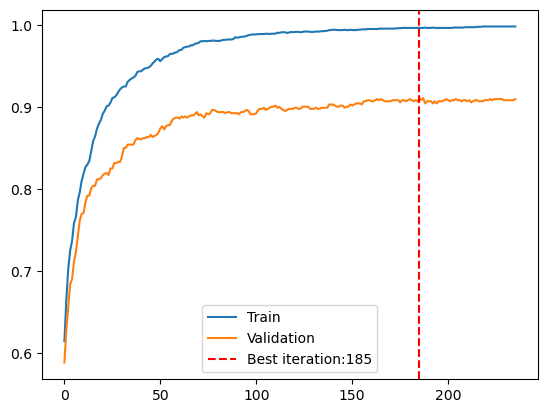

In [316]:
best_iteration = merged_classifier.best_iteration_
plt.plot(merged_classifier.get_evals_result()['learn']['Accuracy'], label = "Train")
plt.plot(merged_classifier.get_evals_result()['validation']['Accuracy'], label = "Validation")
plt.axvline(x=best_iteration, color='red', linestyle='--', label=f'Best iteration:{best_iteration}')
plt.legend();

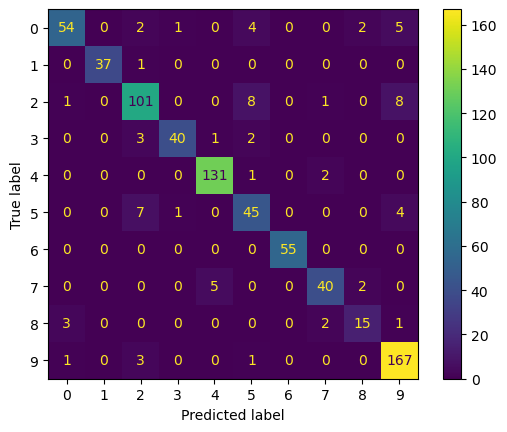

In [319]:
cm = get_confusion_matrix(merged_classifier, test_pool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int),
                                display_labels=merged_classifier.classes_)
disp.plot();

In [320]:
merged_classifier.best_score_

{'learn': {'Accuracy': 0.9986772486772487, 'MultiClass': 0.08534104819861249},
 'validation': {'Accuracy': 0.9113756613756614,
  'MultiClass': 0.3081628506776517}}

In [321]:
pd.concat([v3_accuracy, xc_accuracy, vgg19_accuracy]).reset_index(drop=True)

,learn,validation,model
0,0.992063,0.843915,InceptionV3
1,0.962963,0.826720,Xception
2,0.998236,0.821429,VGG19


In [322]:
y_pred = merged_classifier.predict(test_pool)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.904887714663144

In [323]:
merged_classifier.tree_count_

186

In [293]:
#Check if there are no data leaks LOL

In [292]:
merged_df.columns.str.contains('file_id').sum(), merged_df.columns.str.contains('label').sum()

(1, 1)

In [291]:
merged_df.columns.str.contains('vgg19').sum(), merged_df.columns.str.contains('xc').sum(), merged_df.columns.str.contains('incV3').sum()

(512, 2048, 2048)

# >> [Tuning] CatBoost (InceptionV3 + Xception + VGG19 Features)

In [335]:
def hyperopt_objective(params):
    print(params)
    model = CatBoostClassifier(**params,
                               task_type = 'GPU',
                               loss_function = 'MultiClass',
                               random_seed = RANDOM_SEED)
    
    model.fit(train_pool, verbose=0, eval_set=validation_pool)
    
    y_valid = validation_pool.get_label()
    y_pred = model.predict_proba(validation_pool)
    return  -eval_metric(y_valid, y_pred, 'Accuracy')[0]

space = {
    'learning_rate': hp.loguniform('learning_rate', math.log(0.01), math.log(0.3)), 
    'depth': hp.randint('depth', 3, 10),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', math.log(1), math.log(10))
}

In [336]:
#Uncomment this if you want to do hyperoptimization
# best = fmin(hyperopt_objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10,
#             rstate=np.random.default_rng(RANDOM_SEED))

{'depth': 6, 'l2_leaf_reg': 4.169836222804728, 'learning_rate': 0.15917237508778656}
{'depth': 9, 'l2_leaf_reg': 4.057412493793687, 'learning_rate': 0.02778169688135642}
{'depth': 4, 'l2_leaf_reg': 1.1848435957142298, 'learning_rate': 0.016484730699711236}
{'depth': 7, 'l2_leaf_reg': 1.6301107708185072, 'learning_rate': 0.03948467602347645}
{'depth': 3, 'l2_leaf_reg': 1.2492364447258786, 'learning_rate': 0.055315879907674566}
{'depth': 7, 'l2_leaf_reg': 1.4488522802077135, 'learning_rate': 0.13026382468216652}
{'depth': 4, 'l2_leaf_reg': 9.930868012926428, 'learning_rate': 0.10780126348054113}
{'depth': 3, 'l2_leaf_reg': 6.7622252396425955, 'learning_rate': 0.01244398537983132}
{'depth': 4, 'l2_leaf_reg': 5.907188337611997, 'learning_rate': 0.11705755415853294}
{'depth': 8, 'l2_leaf_reg': 3.023828588476758, 'learning_rate': 0.030207324138548857}
100%|██████████| 10/10 [43:28<00:00, 260.90s/trial, best loss: -0.9272486772486772]


In [340]:
best_params = {'depth': 7,
        'l2_leaf_reg': 1.4488522802077135,
        'learning_rate': 0.13026382468216652}